## Expected Goal model

In [1]:
import numpy
import pandas
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import shap
import matplotlib.pyplot as plt
import scikitplot as skplt

In [2]:
def split_dataset(data, split_rate, output_variable):
    """Split dataset in 4 parts : x_train, y_train, x_test, y_test.
    
    Args:
        data (pandas.Dataframe): dataframe containg shot data.
        split_rate (float): split rate to divide train and test set (often 0.3).
        output_variable (str): target to predict.
        
    Returns:
        (pandas.Dataframe, pandas.Dataframe, pandas.Dataframe, pandas.Dataframe): train and test datasets.
    """
    train_set, test_set = train_test_split(data, test_size=split_rate, random_state=0)
    x_train = train_set.drop(output_variable, axis=1)
    y_train = train_set[output_variable]
    x_test = test_set.drop(output_variable, axis=1)
    y_test = test_set[output_variable]
    return x_train, y_train, x_test, y_test

In [3]:
def evaluation_metrics(y_test, y_pred):
    """
    Compute metrics
    """
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    return {"f1": f1, "accuracy": accuracy, "roc_auc_score": roc}

In [4]:
def print_evaluation_metrics(metrics):
    for key, value in metrics.items():
        print(key.replace("_", " ").upper(), " : ", value)

In [5]:
def plot_evaluation(y_test, y_pred, y_pred_proba):
    fig, axs = plt.subplots(ncols=2, figsize=(20, 5))
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, ax=axs[0])
    skplt.metrics.plot_roc(y_test, y_pred_proba, ax=axs[1])
    plt.plot()

# Load data

For a given shot we have : 
* team id
* player id
* minute
* second
* x coordinate
* y coordinate
* distance from goal
* is the shot is tagged as a "big chance"
* previous event type
* previous x coordinate
* previous y coordinate
* is the shot ends with a goal or not

In [6]:
data = pandas.read_csv("../data/shot_data.csv")
data.head()

,game_id,event_id,team_id,player_id,minute,second,x_shot,y_shot,goal_distance,big_chance,previous_type_name,previous_x,previous_y,is_goal
0,000be874ddf1f5436cb38cfd49fc03c3,2.132958e+09,15,114075,3,50,84.630,26.248,21.795192,0,BallTouch,18.375,38.692,0
1,000be874ddf1f5436cb38cfd49fc03c3,1.259971e+09,15,19729,3,56,95.445,36.040,9.770344,0,Pass,4.095,29.920,0
2,000be874ddf1f5436cb38cfd49fc03c3,1.502744e+09,170,79583,5,57,89.565,36.720,15.672831,0,Save,12.600,30.124,0
3,000be874ddf1f5436cb38cfd49fc03c3,1.685521e+09,170,134331,6,0,78.120,38.284,27.219241,0,Pass,5.250,33.320,0
4,000be874ddf1f5436cb38cfd49fc03c3,1.157283e+09,15,29463,11,48,85.260,38.148,20.171106,0,Clearance,14.175,24.276,0


# Feature Enginnering

In [7]:
def process_data(data):
    data_with_dummies = pandas.get_dummies(data, columns=["previous_type_name"])
    features = ["minute", "second", "x_shot", "y_shot", "goal_distance"] + [feature for feature in list(data_with_dummies.columns) if "previous_type_name" in feature]
    target = ["is_goal"]
    return data_with_dummies[features + target], features, target

In [8]:
processed_data, features, target = process_data(data)

In [9]:
x_train, y_train, x_test, y_test = split_dataset(processed_data, 0.2, "is_goal")

# Modelisation

### XG Boost

In [10]:
model = xgb.XGBClassifier(n_estimators=100, scale_pos_weight=9, max_depth=10, random_state=42)

In [11]:
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=9, seed=None, silent=None,
       subsample=1, verbosity=1)

In [12]:
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1  :  0.4848275862068966
ACCURACY  :  0.8073003998452212
ROC AUC SCORE  :  0.8185534322632957


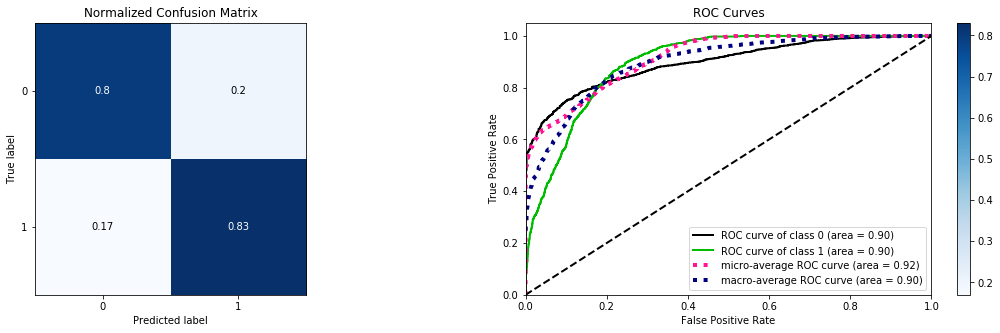

In [13]:
metrics = evaluation_metrics(y_test, y_pred)
print_evaluation_metrics(metrics)
plot_evaluation(y_test, y_pred, y_pred_proba)

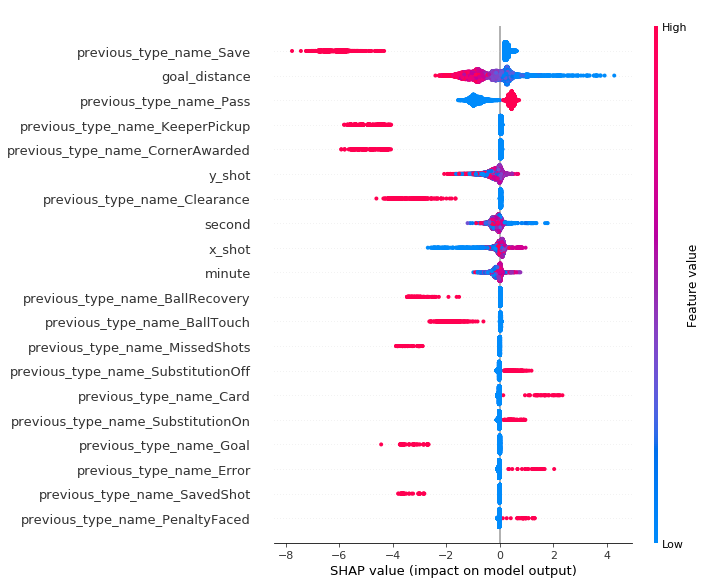

In [15]:
shap_values = shap.TreeExplainer(model).shap_values(x_test)
shap.summary_plot(shap_values, x_test)

### Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
model = RandomForestClassifier(n_estimators=1000)

In [17]:
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)

F1  :  0.34904013961605584
ACCURACY  :  0.9037791822520315
ROC AUC SCORE  :  0.6111017362475897


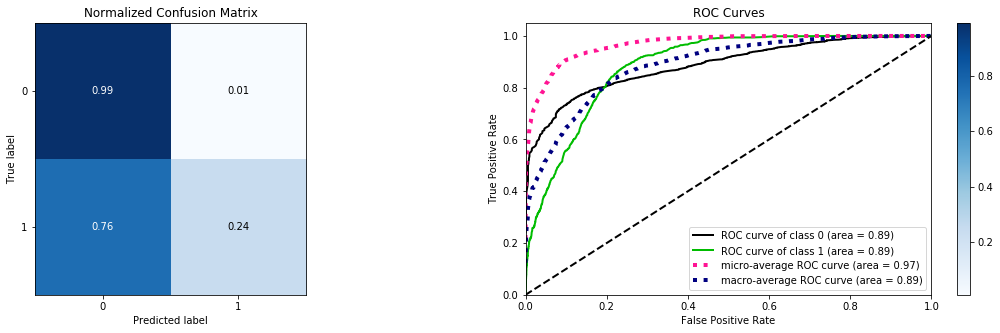

In [19]:
metrics = evaluation_metrics(y_test, y_pred)
print_evaluation_metrics(metrics)
plot_evaluation(y_test, y_pred, y_pred_proba)